# About timeline_viz.ipynb

This notebook uses the functions defined and demontrasted in *utils_timeline_viz.ipynb* to clean log data and visualize it.
This is a work in progress :)

In [1]:
%load_ext autoreload
%autoreload 1
%aimport utils_timeline_viz
from utils_timeline_viz import *
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 25, 15
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
%aimport utils_timeline_viz
studentid = '90447168'
parsed_file = find_student_log_file("beers",studentid)
df = prep_parsing_data(parsed_file)

D:\Applications\Anaconda2\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


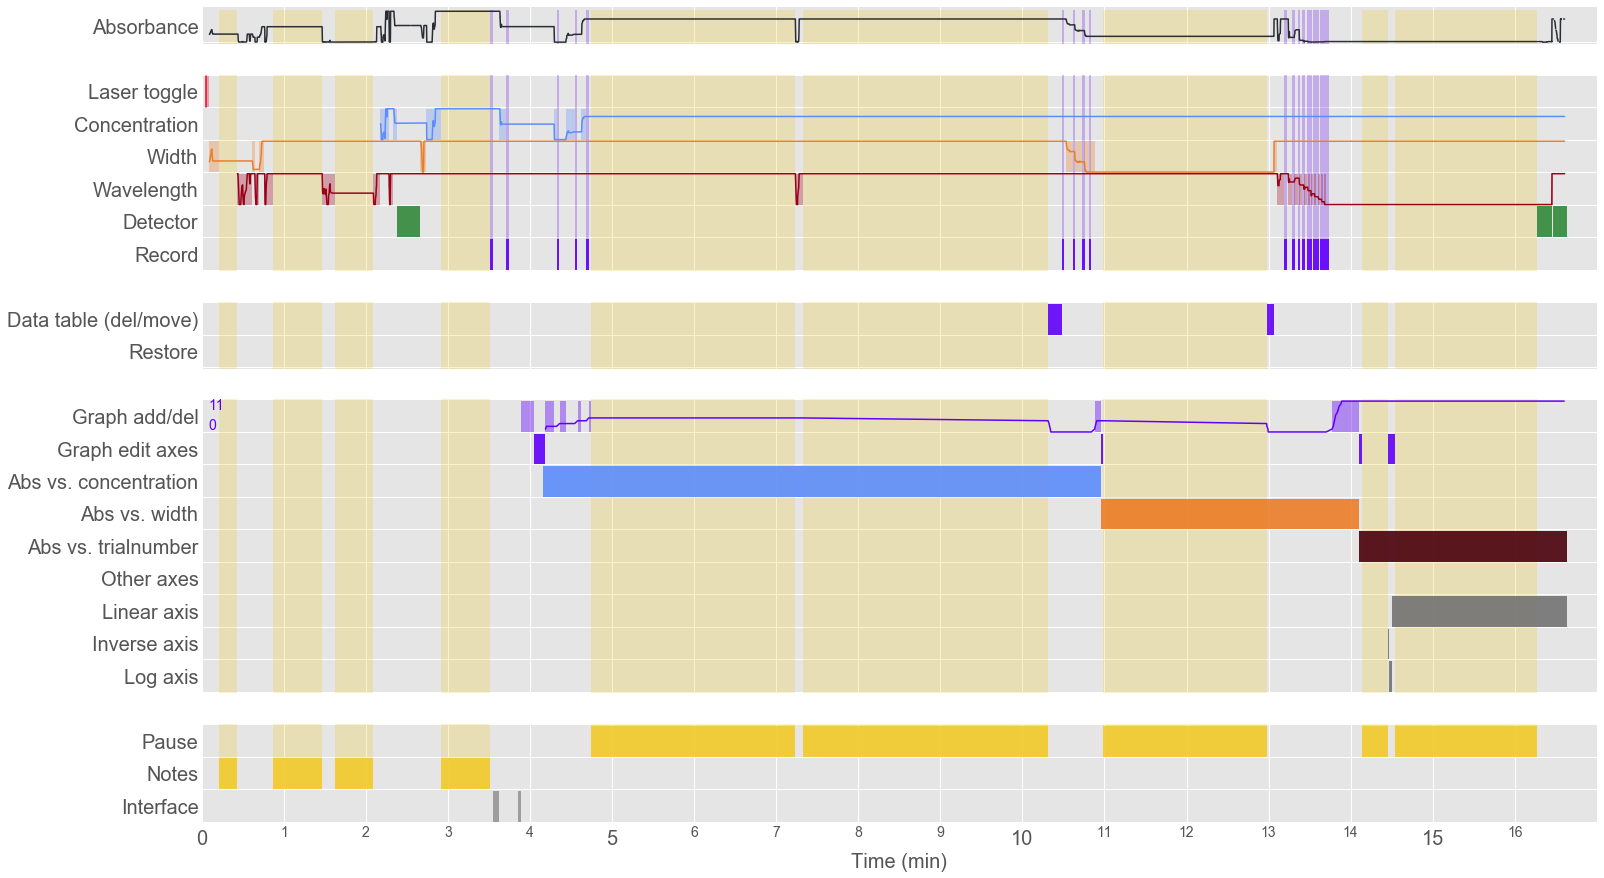

In [3]:
%aimport utils_timeline_viz
plot(df,to_plot_beers,family_name_to_code,function_to_use,colors)

In [4]:
def save_multipage_viz(studentids):
    with PdfPages('multipage_timeline_viz_{0}.pdf'.format('_'.join(studentids))) as pdf:
        for sim,to_plot in [('beers',to_plot_beers),('capacitor',to_plot_caps)]:
            for studentid in studentids:
                filename = find_student_log_file(sim,studentid)
                print filename
                date = date = re.search(r'\d{7,8}_([\d\-\.\_]+)\.txt', filename).group(1)
                df = prep_parsing_data(filename)
                plt.figure(figsize=(20,12))
                plt.title("{1} \t {0} \t {2}".format(studentid,sim,date),fontsize=25)
                plot(df,to_plot,family_name_to_code,function_to_use,colors)
                plt.tight_layout()
                pdf.savefig()
                plt.close()

In [5]:
%aimport utils_timeline_viz
# save_multipage_viz(["90447168","12263156","17597160","17931169","19089138"])

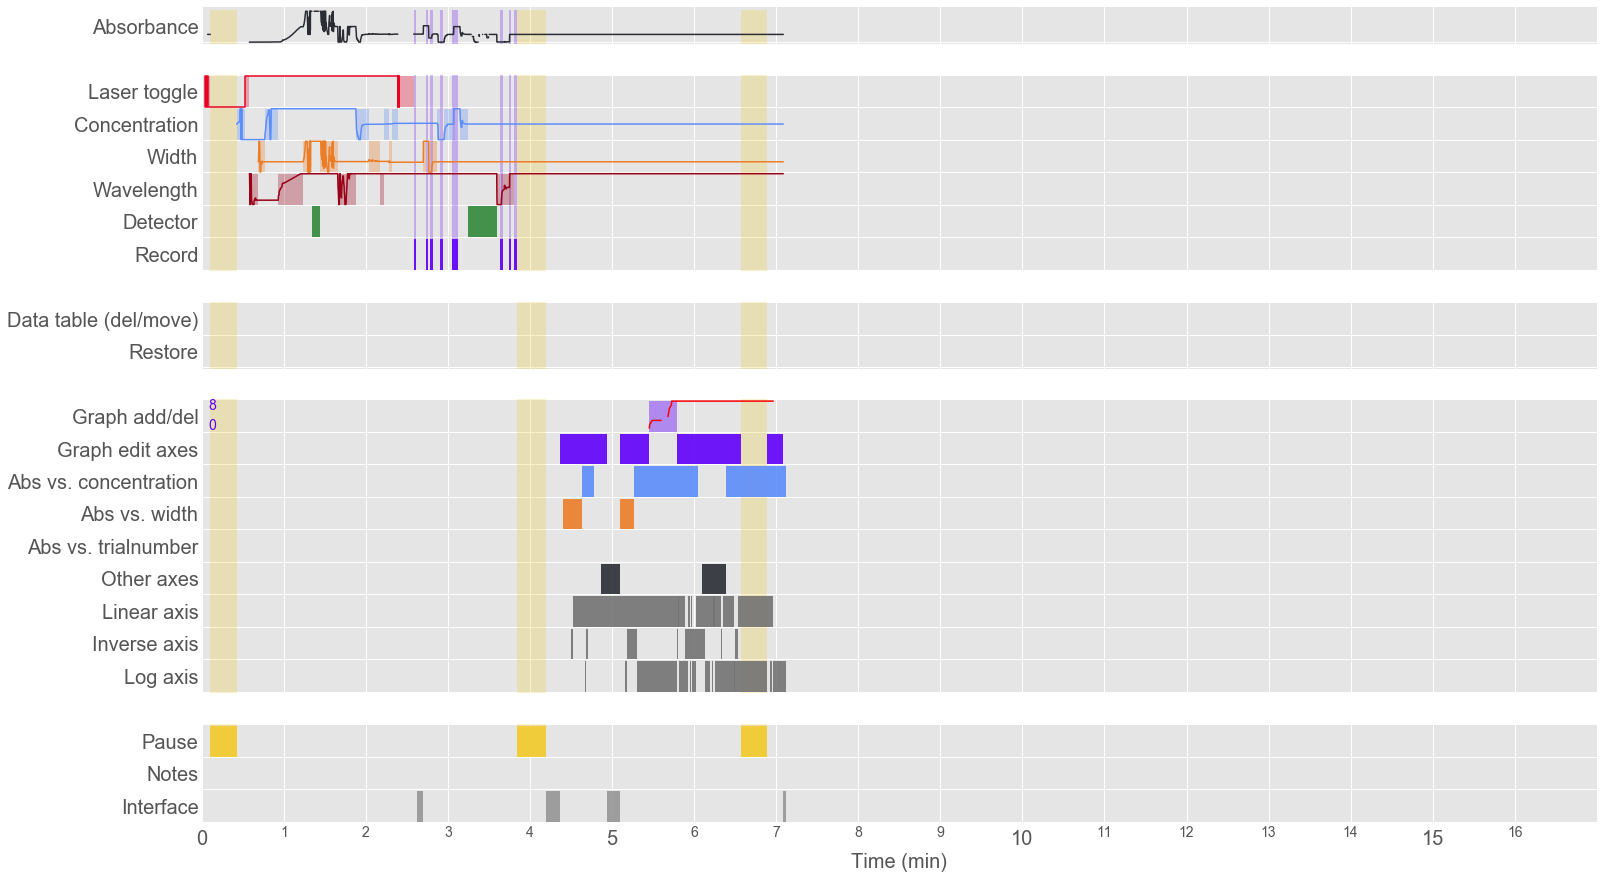

In [6]:
studentid = '12263156';sim = 'beers'
parsed_file = 'dream_table_beers-law-lab_12263156_2017-01-20_15.25.01.txt'
df3 = prep_parsing_data(parsed_file)
plot(df3,to_plot_beers,family_name_to_code,function_to_use,colors)
# plt.savefig(studentid+'_'+sim+'_'+'all.png')

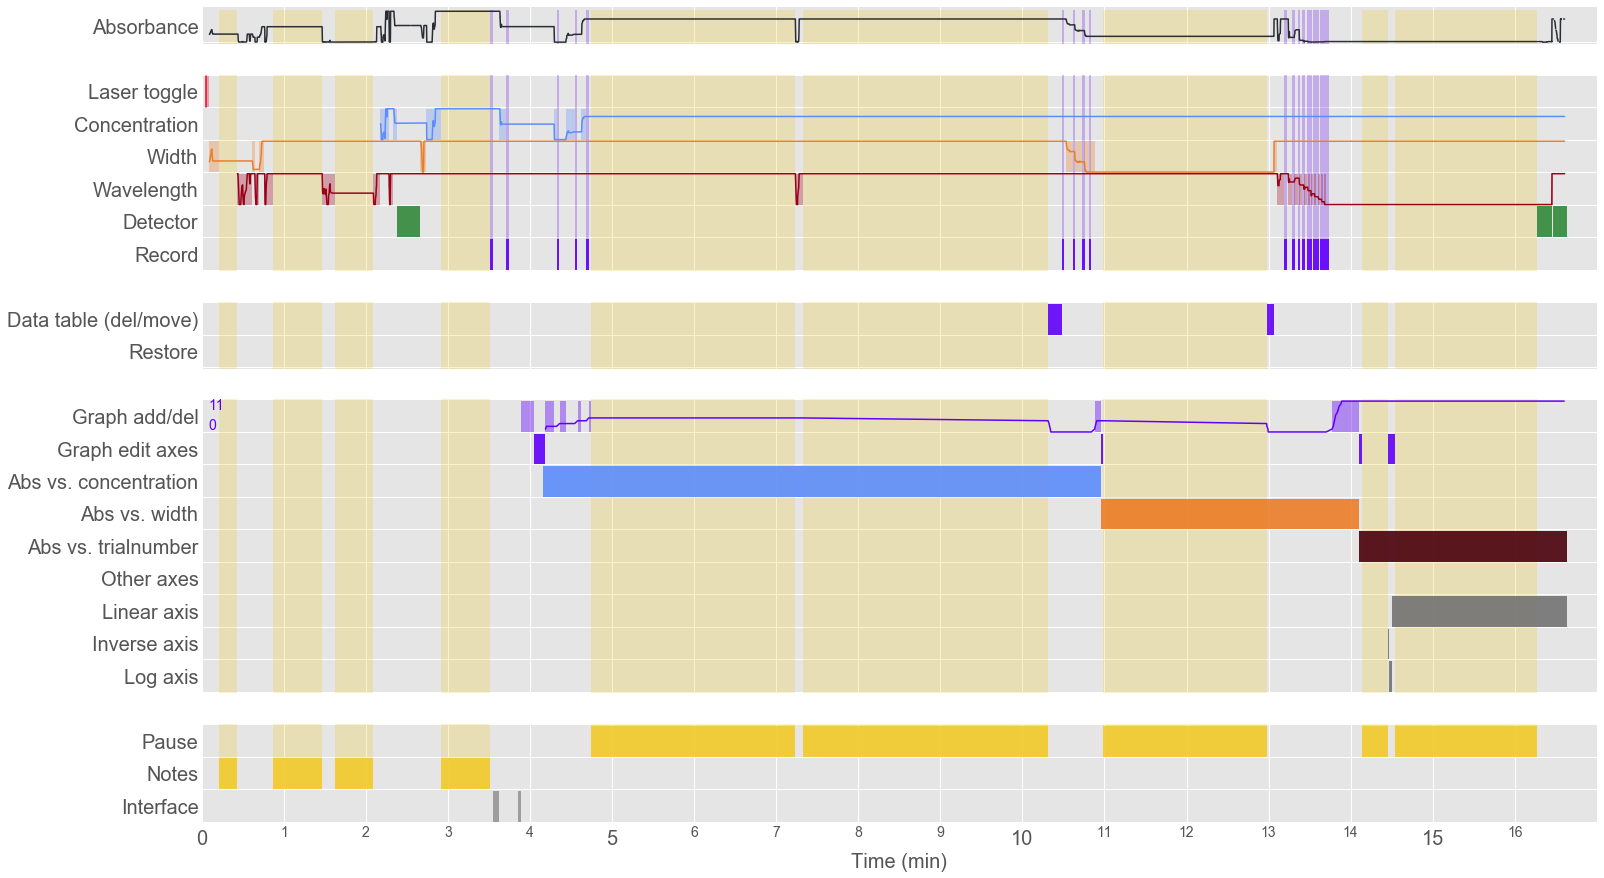

In [7]:
studentid = '90447168';sim = 'beers'
#high pre to high post
#cdw = 333->321
parsed_file = 'dream_table_beers-law-lab_90447168_2017-01-17_11.22.45.txt'
df = prep_parsing_data(parsed_file)
plot(df,to_plot_beers,family_name_to_code,function_to_use,colors)
# plt.savefig(studentid+'_'+sim+'_'+'all.png')

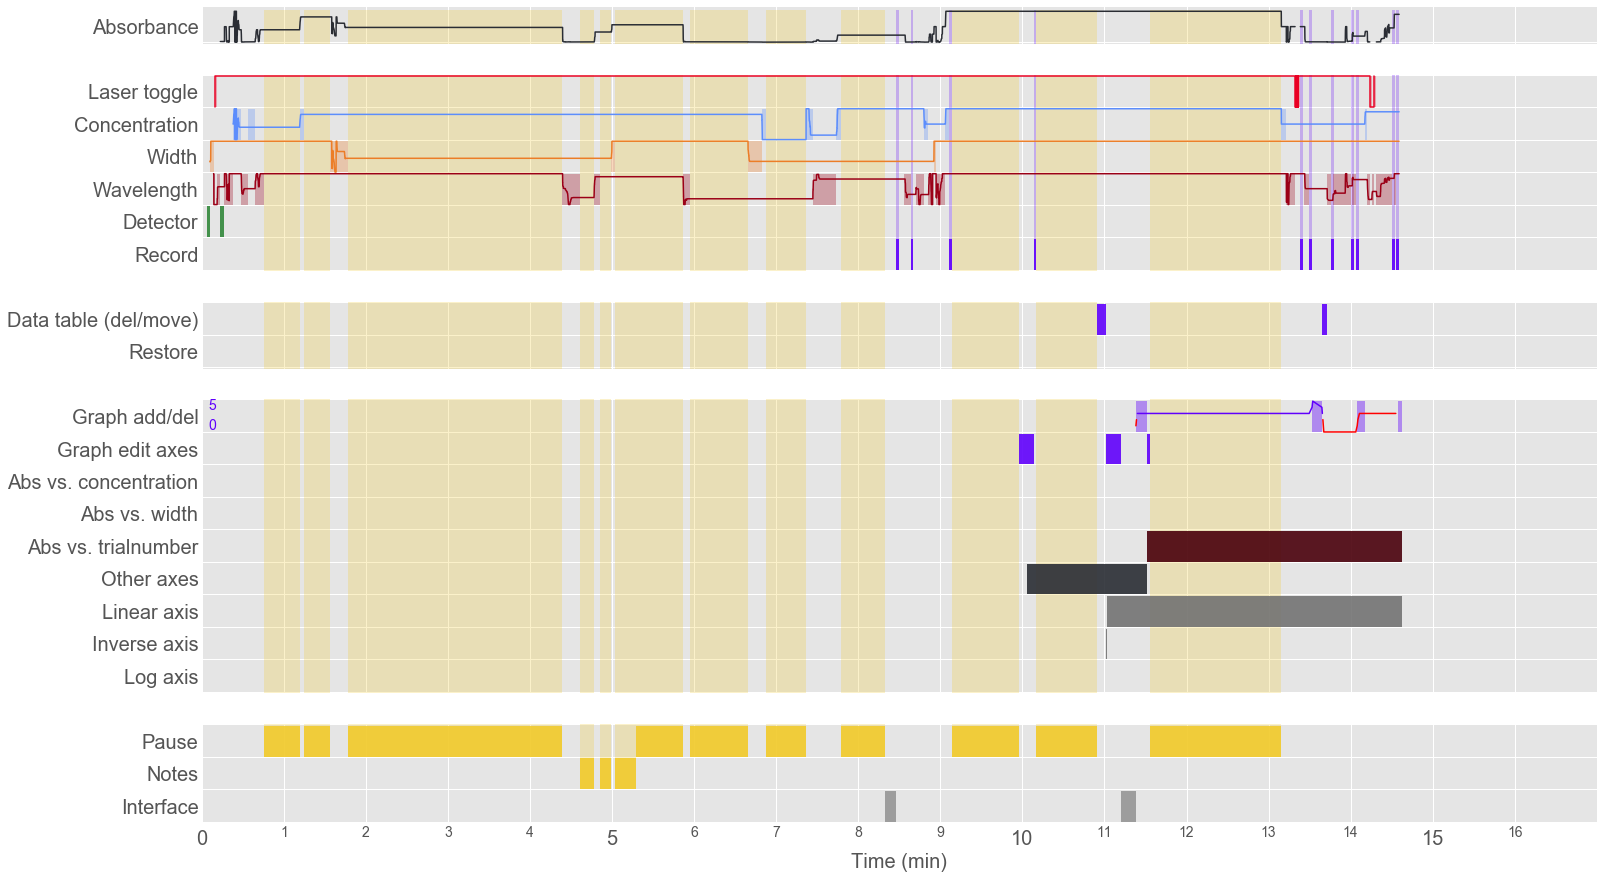

In [8]:
studentid = '19566168';sim = 'beers'
#cdw = 101->222
parsed_file = 'dream_table_beers-law-lab_19566168_2017-01-27_13.27.13.txt'
df2 = prep_parsing_data(parsed_file)
plot(df2,to_plot_beers,family_name_to_code,function_to_use,colors)

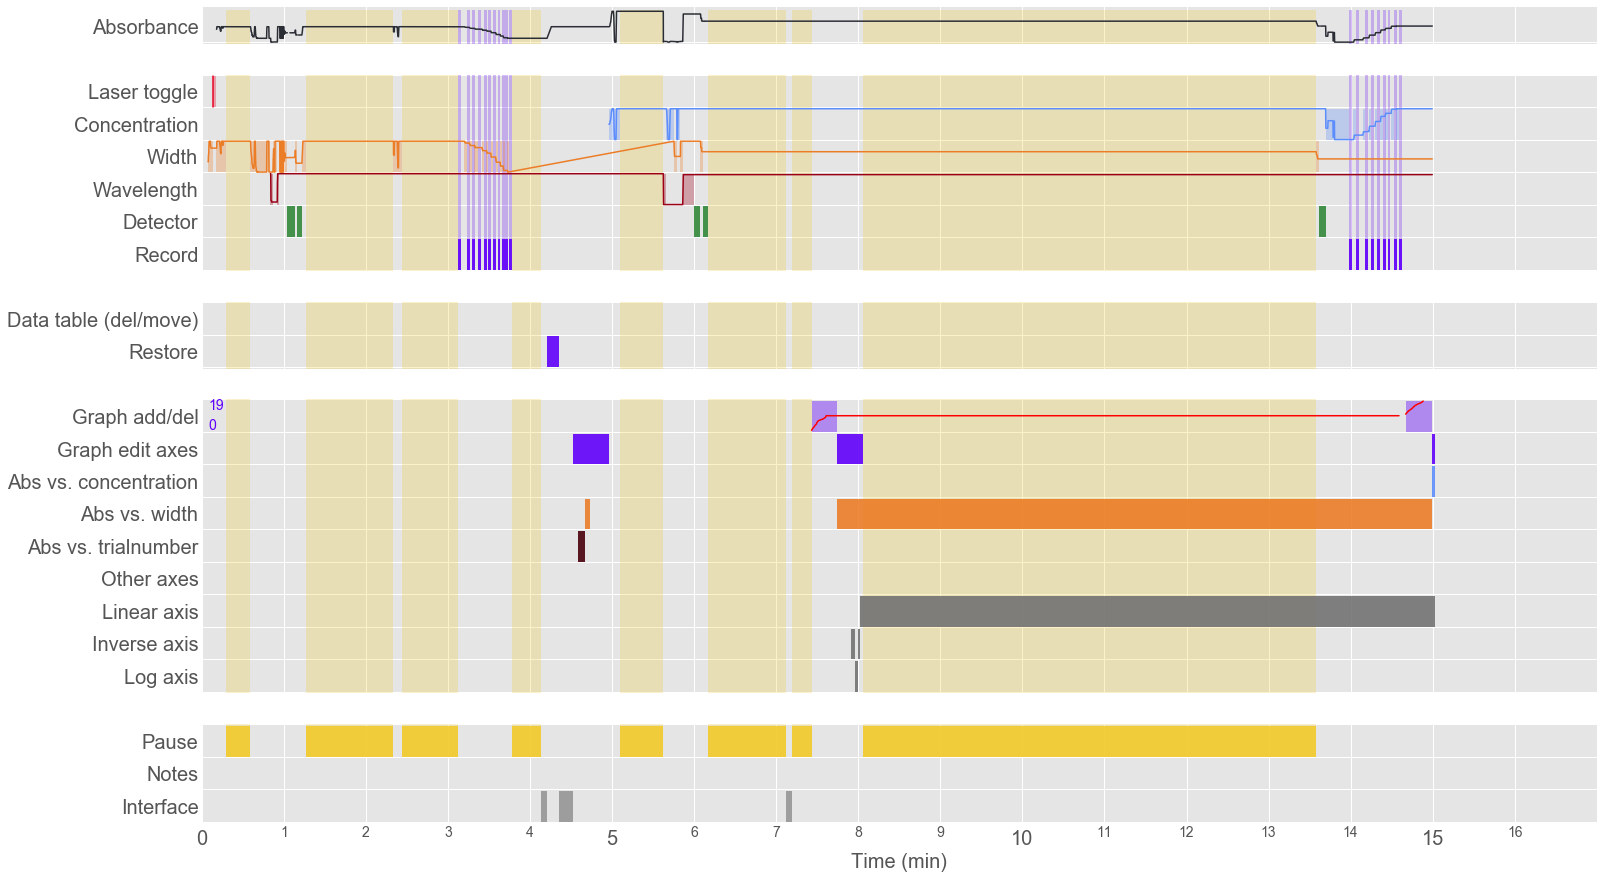

In [9]:
studentid = '16317166'
#main, cdw = 231
parsed_file = find_student_log_file(sim,studentid,date='2017-03-21_17.28.42')
df4 = prep_parsing_data(parsed_file)
plot(df4,to_plot_beers,family_name_to_code,function_to_use,colors)